<a href="https://colab.research.google.com/github/sumansemalty/Stock-Market-Prediction-using-Numerical-and-Textual-Analysis/blob/main/Task7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Suman Semlty**

**Task 7:- Stock Market Prediction using
Numerical and Textual Analysis**

● Objective: Create a hybrid model for stock price/performance
prediction using numerical analysis of historical stock prices, and
sentimental analysis of news headlines


● Stock to analyze and predict - SENSEX (S&P BSE SENSEX)

● Download historical stock prices from finance.yahoo.com

● Download textual (news) data from https://bit.ly/36fFPI6

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
!pip install pmdarima

In [ ]:
df_prices = pd.read_csv('Stock.csv')
print(df_prices.head())
print(df_prices.size)

         Date        Open        High  ...       Close   Adj Close  Volume
0  2000-09-01  277.000000  277.000000  ...  277.000000  277.000000     0.0
1  2000-09-04         NaN         NaN  ...         NaN         NaN     NaN
2  2000-09-05  275.799988  275.799988  ...  275.799988  275.799988     2.0
3  2000-09-06  274.200012  274.200012  ...  274.200012  274.200012     0.0
4  2000-09-07  274.000000  274.000000  ...  274.000000  274.000000   125.0

[5 rows x 7 columns]
37002


In [ ]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5286 entries, 0 to 5285
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5286 non-null   datetime64[ns]
 1   Open       5174 non-null   float64       
 2   High       5174 non-null   float64       
 3   Low        5174 non-null   float64       
 4   Close      5174 non-null   float64       
 5   Adj Close  5174 non-null   float64       
 6   Volume     5174 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 289.2 KB


In [ ]:
df_prices.dropna(inplace = True)

Text(0, 0.5, 'Close')

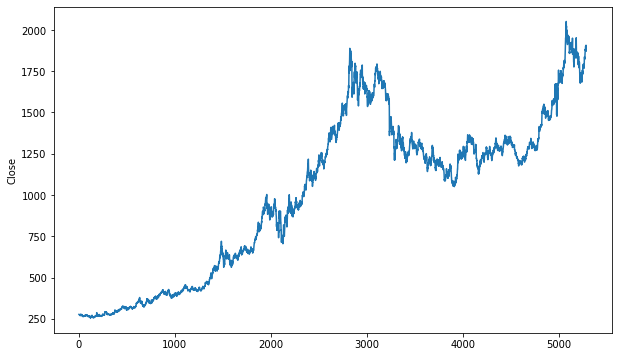

In [ ]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

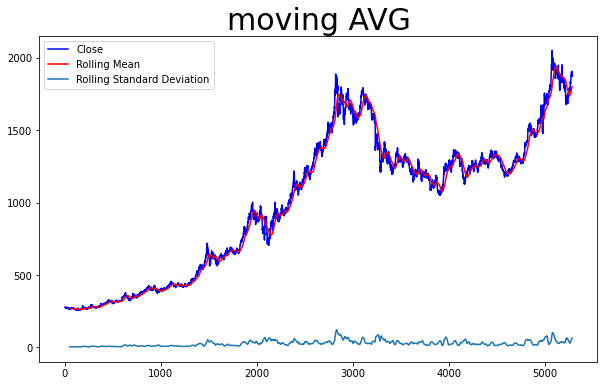

In [ ]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.title("moving AVG", fontsize=30)
plt.legend()

Text(0.5, 1.0, 'Returns')

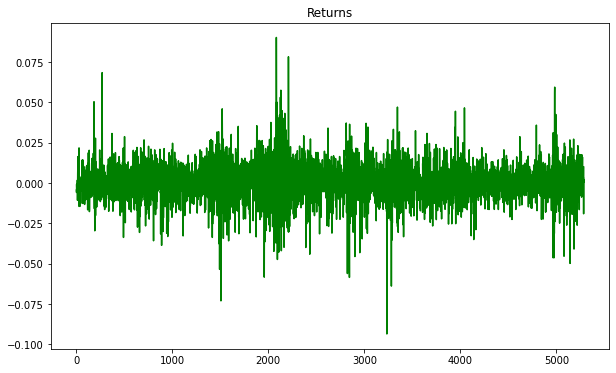

In [ ]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [ ]:
train = df_prices[:1000]
test = df_prices[1000:]

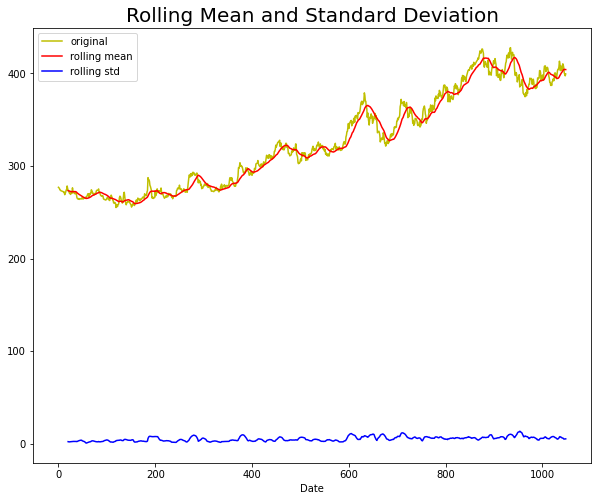

Results of dickey fuller test
ADF Test Statistic : -0.6477380671676234
p-value : 0.8598263186550376
#Lags Used : 1
Number of Observations Used : 998
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

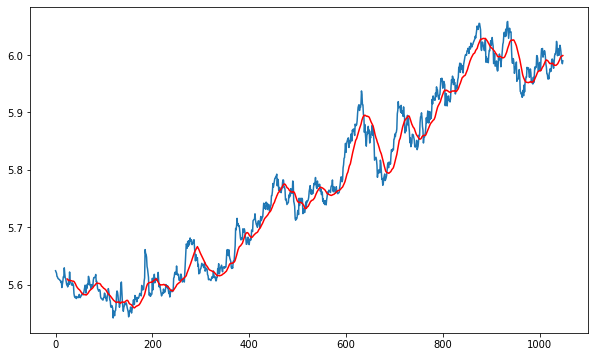

In [ ]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

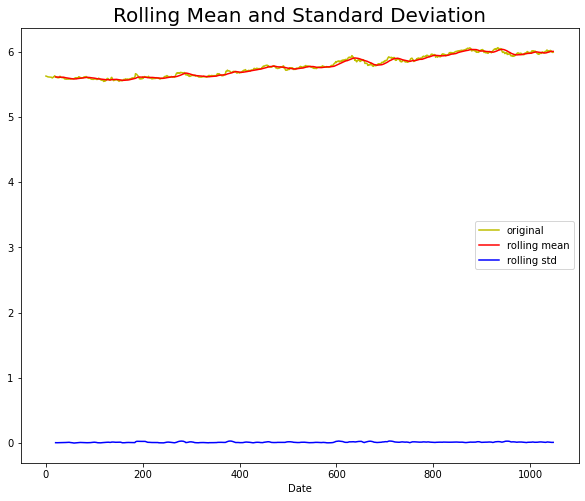

Results of dickey fuller test
ADF Test Statistic : -0.7367879700870202
p-value : 0.8369891657383053
#Lags Used : 2
Number of Observations Used : 997
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

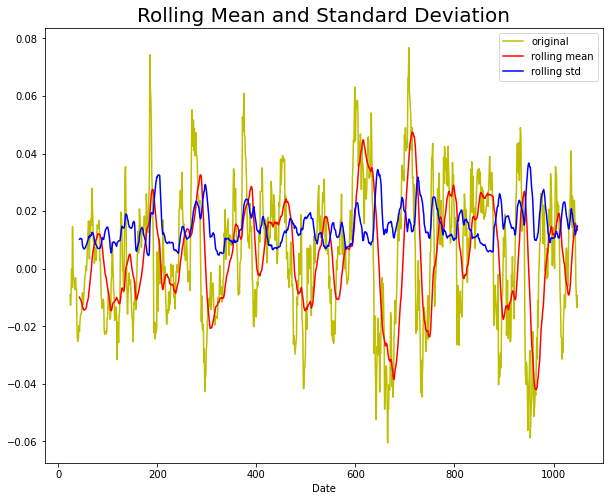

Results of dickey fuller test
ADF Test Statistic : -6.543270856667298
p-value : 9.232619983870423e-09
#Lags Used : 2
Number of Observations Used : 974
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [ ]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [ ]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

In [ ]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [ ]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

TEXTUAL ANALYSIS

In [ ]:
cols = ['Date','Category','News']
df_news = pd.read_csv('india-news-headlines.csv', names = cols)
df_news

In [ ]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

In [ ]:
#Converting data type of Date column 
 df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
 df_news

In [ ]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

In [ ]:
df_news['News']


In [ ]:
#Cleaning headlines
c = []
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [ ]:
df_news['News'] = pd.Series(c)
df_news

In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

In [ ]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

In [ ]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [ ]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

In [ ]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

In [ ]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

In [ ]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [ ]:
X.head()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

In [ ]:
x_train[:10]

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [ ]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

In [ ]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [ ]:
print(mean_squared_error(predictions, y_test))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [ ]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

In [ ]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

In [ ]:
redictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

In [ ]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))